<p align="left">
  <a href="https://colab.research.google.com/github/fernandoarcevega/AI_Workshop/blob/main/Day_1/02_Naive_Bayes/02_naiveBayes_mnl.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" width="200">
  </a>
</p>

In [ ]:
###############################################
# Author 1: Wilfrido Gómez-Flores (CINVESTAV) #
# Author 2: Fernando Arce-Vega (CIO)          #
# e-mail 1: wilfrido.gomez@cinvestav.mx       #
# e-mail 2: farce@cio.mx                      #
# Date:     nov/03/2025                       #
# Subject:  Naive Bayes                       #
###############################################

In [ ]:
# Libraries
import numpy as np                                                    # Numerical array operations
import pandas as pd                                                   # Data manipulation/analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Model evaluation
import matplotlib.pyplot as plt                                       # Data plotting/visualization

In [ ]:
# Other functions
!wget -q https://raw.githubusercontent.com/fernandoarcevega/AI_Workshop/main/helpers/misc.py
from misc import *

In [ ]:
# Load dataset
# Path to dataset
path = 'https://raw.githubusercontent.com/fernandoarcevega/AI_Workshop/main/datasets/mias_data.csv'
T = pd.read_csv(path)
data = T.values
n, d = data.shape
X = data[:, :d-1]   # Features
Y = data[:, d-1]    # Class labels

In [ ]:
# Check feature and targets shapes
print(f'Features shape: {X.shape}')
print(f'Targets shape:  {Y.shape}')

Features shape: (322, 63)
Targets shape:  (322,)


 🔵 🔵 🔵 🔵 🔵 🔵 🔵 🔵 🔵 🔵  (Total data)

 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟢 🟡 🟡  (Training and testing data)

In [ ]:
# Split dataset into training and test sets (80%-20%)
tr, tt = HoldOut(Y, 0.2)

# Training set
Xtr = X[tr, :]
Ytr = Y[tr]

# Test set
Xtt = X[tt, :]
Ytt = Y[tt]

In [ ]:
# Check feature and targets shapes for training and test sets
print(f'Training features shape: {Xtr.shape}')
print(f'Training targets shape:  {Ytr.shape} \n')
print(f'Testing features shape:  {Xtt.shape}')
print(f'Testing targets shape:   {Ytt.shape}')

Training features shape: (258, 63)
Training targets shape:  (258,) 

Testing features shape:  (64, 63)
Testing targets shape:   (64,)


# Data normalization
$
X'=\frac{X-μ_i}{σ_i}
$

In [ ]:
# Data normalization
Xtr, stats = zscorenorm(Xtr)
Xtt = zscorenorm(Xtt, stats)

In [ ]:
# Check feature and targets shapes for training and test sets
print(f'Training features shape: {Xtr.shape}\n')
print(f'Testing features shape:  {Xtt.shape}')

Training features shape: (258, 63)

Testing features shape:  (64, 63)


The **prior probability** is calculated as the proportion of elements of class $\omega_i$:

$$ p(\omega_i) = \frac{n_i}{n}, \quad \text{where} \quad n_i = \sum_{j=1}^{n} \mathbf{1}_{\omega_i}(y_j) $$


In [ ]:
def NaiveBayesTrain(X, Y):
    c = np.unique(Y)  # Classes
    nc = len(c)       # Number of classes
    n, d = X.shape    # Dimensionality and number of samples

    Mdl = {
        'Classes': c,
        'Mean': np.zeros((nc, d)),  # Mean
        'Var': np.zeros((nc, d)),   # Variance
        'Prior': np.zeros(nc)       # Prior
    }

    for i in range(nc):
        id = (Y == c[i])                              # Samples of ith class (ni)
        Mdl['Mean'][i, :] = np.mean(X[id, :], axis=0) # Mean vector
        Mdl['Var'][i, :] = np.var(X[id, :], axis=0)   # Variance vector
        Mdl['Prior'][i] = np.sum(id) / n              # Prior

    return Mdl

The computation of the **likelihood function** in (2) is simplified to the product of univariate normal densities:

$$
\begin{align*}
p(\mathbf{x}|\omega_i) &= \prod_{j=1}^{d} p(x_j|\omega_i), \quad i=1, \dots, c, \\
&= \prod_{j=1}^{d} \frac{1}{(2\pi\sigma_{ij}^2)^{1/2}} \exp\left\{-\frac{1}{2\sigma_{ij}^2}(x_j - \mu_{ij})^2\right\}
\end{align*}
$$

where $\mu_{ij}$ and $\sigma_{ij}^2$ are the mean and variance of the *i*th class and the *j*th feature, respectively.

It is based on Bayes' rule to calculate the **posterior probability** of class $\omega_i \in \Omega = \{\omega_1, \dots, \omega_c\}$ given the feature vector **x**:

$$ p(\omega_i|\mathbf{x}) = \frac{p(\mathbf{x}|\omega_i)p(\omega_i)}{\sum_{l=1}^{c} p(\mathbf{x}|\omega_l)p(\omega_l)} $$

In [ ]:
def NaiveBayesPredict(X, Mdl):

    # Likelihood function times prior
    def g(x, m, s, p):

        return np.prod((1. / np.sqrt(2 * np.pi * s)) * np.exp(-(1. / (2 * s)) * (x - m) ** 2)) * p

    n = X.shape[0]            # number of test samples
    nc = len(Mdl['Classes'])  # number of classes
    Prb = np.zeros((n, nc))   # posterior probabilities

    for i in range(nc):
        for j in range(n):
            Prb[j, i] = g(X[j, :], Mdl['Mean'][i, :], Mdl['Var'][i, :], Mdl['Prior'][i])

    Prb = Prb / np.sum(Prb, axis=1, keepdims=True)  # Bayes' Theorem
    idx = np.argmax(Prb, axis=1)
    Ypp = Mdl['Classes'][idx]                       # Predicted class labels

    return Ypp, Prb

In [ ]:
# Train model
Mdl = NaiveBayesTrain(Xtr, Ytr)

In [ ]:
# Classify test data
Ypp, Prb = NaiveBayesPredict(Xtt, Mdl)

In [ ]:
# Print classification error
err = np.mean(Ypp != Ytt)
print(f'Error: {100 * err:.3f}%')

Error: 42.188%


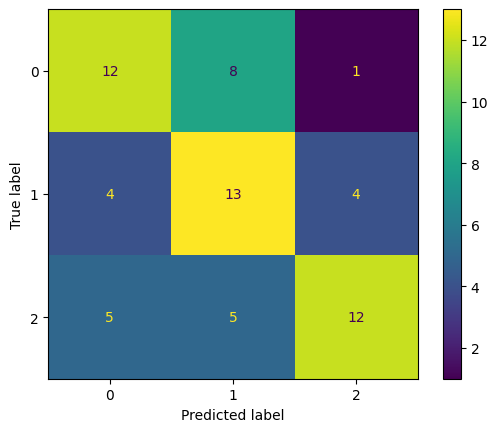

In [ ]:
# Confusion matrix
cm = confusion_matrix(Ytt, Ypp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()